### Generate Insight into the correlation between Error- and UQ Maps of the reconstruction (R1 vs R3 or R6)


In [ ]:
import sqlite3
import pandas as pd
from pathlib import Path


# === Configurable Parameters ===
db_fpath  = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db')
table     = "uq_vs_error_correlation_cv"  # or remove _debug if running final
verbose   = True|

In [3]:
# === SQLite DB Utilities ===

def connect_db(db_path: Path) -> sqlite3.Connection:
    """Establish and return SQLite connection."""
    return sqlite3.connect(str(db_path))

def run_query(conn: sqlite3.Connection, query: str) -> pd.DataFrame:
    """Execute a SQL query and return the result as a DataFrame."""
    return pd.read_sql_query(query, conn)

def preview_table(conn: sqlite3.Connection, table_name: str, n: int = 5):
    """Print the first n rows of the specified table."""
    df = run_query(conn, f"SELECT * FROM {table_name} LIMIT {n};")
    display(df)

# === Establish Connection ===
conn = connect_db(db_fpath)

# === Preview Table (Optional) ===
if verbose:
    print(f"🔍 Preview of '{table}' table:")
    preview_table(conn, table)


🔍 Preview of 'uq_vs_error_correlation_cv' table:


,pat_id,slice_idx,acc_factor,uq_method,region,mean_abs,mean_uq,std_uq,pearson_corr,spearman_corr
0,0007_ANON1586301,0,3,lxo,slice,8.870602,0.046968,0.031863,-0.197555,-0.234798
1,0007_ANON1586301,1,3,lxo,slice,8.618157,0.044817,0.028050,-0.226384,-0.249307
2,0007_ANON1586301,2,3,lxo,slice,7.898169,0.046112,0.029267,-0.194621,-0.196649
3,0007_ANON1586301,3,3,lxo,slice,7.794737,0.046244,0.030563,-0.215576,-0.225823
4,0007_ANON1586301,4,3,lxo,slice,7.459841,0.046642,0.028982,-0.217356,-0.231060


1. Which UQ Method Aligns Better With Error?
🔍 Compare Spearman/Pearson correlation between UQ and error per method

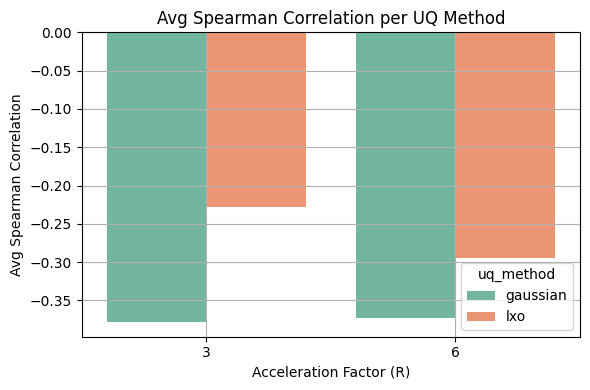

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- SQL Query: Mean correlation per method ---
query = f"""
SELECT uq_method, acc_factor,
       AVG(spearman_corr) AS avg_spearman_corr,
       COUNT(*) AS n
FROM {table}
WHERE region = 'slice'
GROUP BY uq_method, acc_factor;
"""

# --- Run Query ---
df_corr_summary = run_query(conn, query)

# --- Plot ---
plt.figure(figsize=(6, 4))
sns.barplot(data=df_corr_summary, x="acc_factor", y="avg_spearman_corr", hue="uq_method", palette="Set2")
plt.title("Avg Spearman Correlation per UQ Method")
plt.ylabel("Avg Spearman Correlation")
plt.xlabel("Acceleration Factor (R)")
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Next: Boxplot Per Slice × Region
Let’s expand your boxplot to include region, so we don’t over-average.

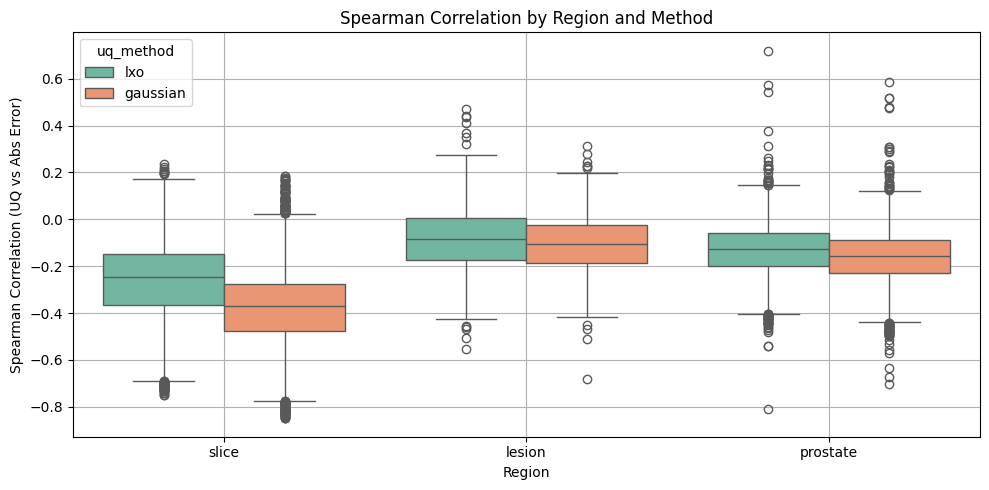

In [5]:
# --- Pull all slice-level correlations including region ---
query = f"""
SELECT uq_method, acc_factor, region, spearman_corr
FROM {table}
WHERE spearman_corr IS NOT NULL;
"""
df = run_query(conn, query)

# --- Plot ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="region", y="spearman_corr", hue="uq_method", palette="Set2")
plt.title("Spearman Correlation by Region and Method")
plt.xlabel("Region")
plt.ylabel("Spearman Correlation (UQ vs Abs Error)")
plt.grid(True)
plt.tight_layout()
plt.show()


🎻 Next Jupyter Cell: Violin Plots per Region × UQ Method

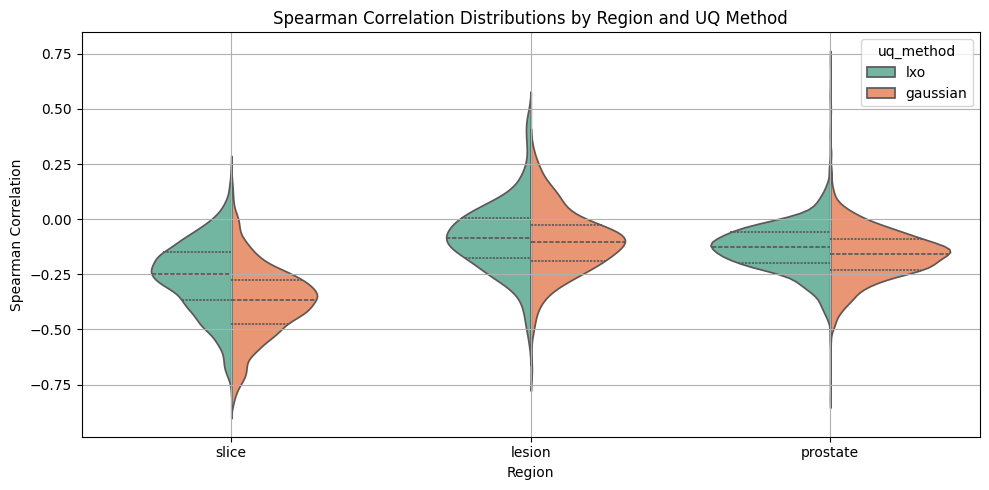

In [6]:
# --- Violin plot of Spearman correlation distributions ---
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="region", y="spearman_corr", hue="uq_method", palette="Set2", split=True, inner="quartile")
plt.title("Spearman Correlation Distributions by Region and UQ Method")
plt.xlabel("Region")
plt.ylabel("Spearman Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()


🔹 1. Facet Plots: Add Acceleration
Add acc_factor as a facet to all your plots (boxplots or violins):

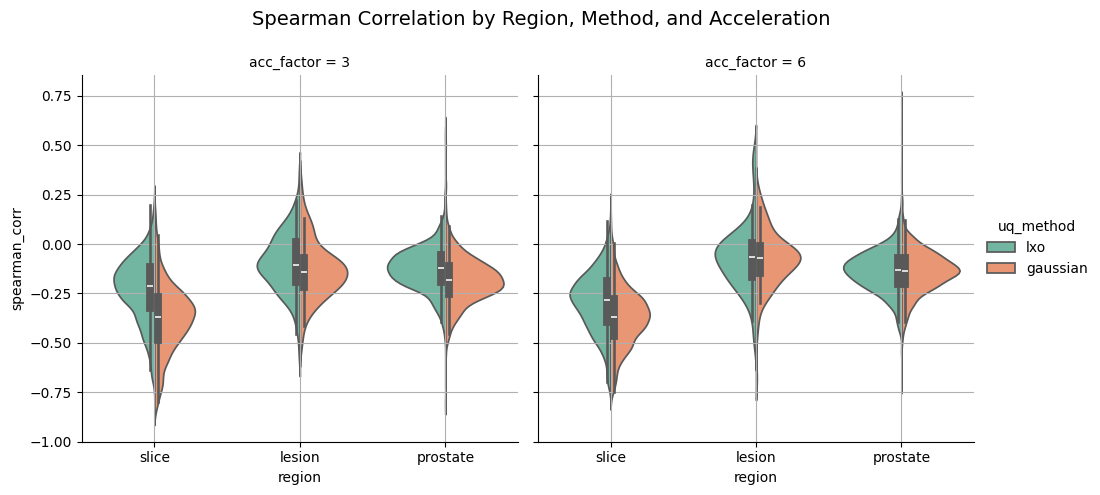

In [8]:
# --- Faceted Violin Plots by Acceleration Factor with Grid Lines ---
g = sns.catplot(
    data=df,
    x="region", y="spearman_corr", hue="uq_method",
    col="acc_factor", kind="violin", split=True,
    palette="Set2", height=5, aspect=1
)

# Add grid lines to each subplot
for ax in g.axes.flat:
    ax.grid(True)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Spearman Correlation by Region, Method, and Acceleration", fontsize=14)
plt.show()


🧪 Next Cell: Mixed Effects Model (in Python via statsmodels)

In [10]:
import statsmodels.formula.api as smf

# Filter to valid rows
df_model = df.dropna(subset=["spearman_corr"])

# Fit a linear mixed effects model with patient as random effect
model = smf.mixedlm(
    "spearman_corr ~ uq_method * acc_factor * region",
    df_model,
    groups=df_model["pat_id"]
).fit()

# Display summary
print(model.summary())

df["region"] = df["region"].astype("category")
df["uq_method"] = df["uq_method"].astype("category")
df["pat_id"] = df["pat_id"].astype("category")



KeyError: 'pat_id'